# Engineering a training dataset
In this notebook we will create a dataset to train a regression model, and guess customer engagement with an uploaded recipe
We will follow our planning created from the first exploration of the data:


![table](../images/table-planning.jpg)


# We start shaping the MVP data


In [43]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline
import datetime

start using RAW_interactions to score the interactions per recipes. 

In [2]:
interactions = pd.read_csv("../data/RAW_interactions.csv")
interactions.head()

,user_id,recipe_id,date,rating,review
0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for...
1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall..."
2,8937,44394,2002-12-01,4,This worked very well and is EASY. I used not...
3,126440,85009,2010-02-27,5,I made the Mexican topping and took it to bunk...
4,57222,85009,2011-10-01,5,"Made the cheddar bacon topping, adding a sprin..."


In [3]:
interactions.rename(columns = {'date':'interaction_date','recipe_id':'id'}, inplace = True)

In [4]:
interactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1132367 entries, 0 to 1132366
Data columns (total 5 columns):
 #   Column            Non-Null Count    Dtype 
---  ------            --------------    ----- 
 0   user_id           1132367 non-null  int64 
 1   id                1132367 non-null  int64 
 2   interaction_date  1132367 non-null  object
 3   rating            1132367 non-null  int64 
 4   review            1132198 non-null  object
dtypes: int64(3), object(2)
memory usage: 43.2+ MB


we need to use pandas_groupby to start calculating aggregations

In [5]:
recipes = pd.read_csv("../data/RAW_recipes.csv")
recipes.head()

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13
3,alouette potatoes,59389,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","['spreadable cheese with garlic and herbs', 'n...",11
4,amish tomato ketchup for canning,44061,190,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,"['tomato juice', 'apple cider vinegar', 'sugar...",8


As the database covers up to end of 2018 interactions, we will use 2018-12-31 as the reference day, as if we were doing this analysis then. 

In [44]:
REF_DAY = datetime.datetime(2018, 12, 31, 0, 0)

Now I want to bring over the subitted day of each recipe into the interaction dataset. 

In [7]:
submission_table = recipes[['id','submitted','contributor_id']]
submission_table.head()

,id,submitted,contributor_id
0,137739,2005-09-16,47892
1,31490,2002-06-17,26278
2,112140,2005-02-25,196586
3,59389,2003-04-14,68585
4,44061,2002-10-25,41706


In [8]:
interactions = interactions.merge(submission_table, on='id')
interactions.head()

,user_id,id,interaction_date,rating,review,submitted,contributor_id
0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for...,2002-09-21,1533
1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall...",2002-09-21,1533
2,8937,44394,2002-12-01,4,This worked very well and is EASY. I used not...,2002-10-27,56824
3,126440,85009,2010-02-27,5,I made the Mexican topping and took it to bunk...,2004-02-25,64342
4,57222,85009,2011-10-01,5,"Made the cheddar bacon topping, adding a sprin...",2004-02-25,64342


In [9]:
interactions['interaction_date'] = pd.to_datetime(interactions['interaction_date'])
interactions['submitted'] = pd.to_datetime(interactions['submitted'])

In [10]:
interactions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1132367 entries, 0 to 1132366
Data columns (total 7 columns):
 #   Column            Non-Null Count    Dtype         
---  ------            --------------    -----         
 0   user_id           1132367 non-null  int64         
 1   id                1132367 non-null  int64         
 2   interaction_date  1132367 non-null  datetime64[ns]
 3   rating            1132367 non-null  int64         
 4   review            1132198 non-null  object        
 5   submitted         1132367 non-null  datetime64[ns]
 6   contributor_id    1132367 non-null  int64         
dtypes: datetime64[ns](2), int64(4), object(1)
memory usage: 69.1+ MB


In [11]:
interactions['days_after_sub'] = [d.days for d in (interactions['interaction_date']-interactions['submitted'])]

In [12]:
interactions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1132367 entries, 0 to 1132366
Data columns (total 8 columns):
 #   Column            Non-Null Count    Dtype         
---  ------            --------------    -----         
 0   user_id           1132367 non-null  int64         
 1   id                1132367 non-null  int64         
 2   interaction_date  1132367 non-null  datetime64[ns]
 3   rating            1132367 non-null  int64         
 4   review            1132198 non-null  object        
 5   submitted         1132367 non-null  datetime64[ns]
 6   contributor_id    1132367 non-null  int64         
 7   days_after_sub    1132367 non-null  int64         
dtypes: datetime64[ns](2), int64(5), object(1)
memory usage: 77.8+ MB


In [13]:
interactions.head()

,user_id,id,interaction_date,rating,review,submitted,contributor_id,days_after_sub
0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for...,2002-09-21,1533,149
1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall...",2002-09-21,1533,3378
2,8937,44394,2002-12-01,4,This worked very well and is EASY. I used not...,2002-10-27,56824,35
3,126440,85009,2010-02-27,5,I made the Mexican topping and took it to bunk...,2004-02-25,64342,2194
4,57222,85009,2011-10-01,5,"Made the cheddar bacon topping, adding a sprin...",2004-02-25,64342,2775


We will do the sentiment analysis now before calculating these aggregations 

In [14]:
from textblob import TextBlob

In [15]:
pol = lambda x: TextBlob(x).polarity

In [16]:
# this takes a while to go through the whole column
# TRY if TQDM works in list comprehensions 
interactions['review_pol'] = [pol(str(rev)) for rev in interactions['review']]

In [17]:
interactions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1132367 entries, 0 to 1132366
Data columns (total 9 columns):
 #   Column            Non-Null Count    Dtype         
---  ------            --------------    -----         
 0   user_id           1132367 non-null  int64         
 1   id                1132367 non-null  int64         
 2   interaction_date  1132367 non-null  datetime64[ns]
 3   rating            1132367 non-null  int64         
 4   review            1132198 non-null  object        
 5   submitted         1132367 non-null  datetime64[ns]
 6   contributor_id    1132367 non-null  int64         
 7   days_after_sub    1132367 non-null  int64         
 8   review_pol        1132367 non-null  float64       
dtypes: datetime64[ns](2), float64(1), int64(5), object(1)
memory usage: 86.4+ MB


<AxesSubplot:>

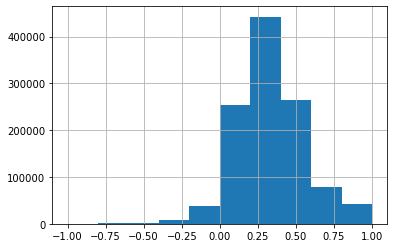

In [18]:
interactions.review_pol.hist()

In [19]:
interactions = interactions[['id',
                             'user_id',
                             'review',
                             'rating',
                             'interaction_date',
                             'submitted',
                             'contributor_id',
                             'days_after_sub',
                             'review_pol']]
interactions.head()

,id,user_id,review,rating,interaction_date,submitted,contributor_id,days_after_sub,review_pol
0,40893,38094,Great with a salad. Cooked on top of stove for...,4,2003-02-17,2002-09-21,1533,149,0.270000
1,40893,1293707,"So simple, so delicious! Great for chilly fall...",5,2011-12-21,2002-09-21,1533,3378,0.242857
2,44394,8937,This worked very well and is EASY. I used not...,4,2002-12-01,2002-10-27,56824,35,0.366667
3,85009,126440,I made the Mexican topping and took it to bunk...,5,2010-02-27,2004-02-25,64342,2194,0.350000
4,85009,57222,"Made the cheddar bacon topping, adding a sprin...",5,2011-10-01,2004-02-25,64342,2775,-0.208333


Save in a clean dataframe to be used later in tableau for more exploratory analysis

In [20]:
interactions.to_csv("../data/clean-data/interactions_clean.csv")

Now we calculate aggregations in order to enrich the recipe dataframe

In [69]:
interactions = pd.read_csv("../data/clean-data/interactions_clean.csv")

In [70]:
interaction_nums = interactions[['id','user_id','rating','days_after_sub','review_pol']]

In [71]:
interaction_nums

,id,user_id,rating,days_after_sub,review_pol
0,40893,38094,4,149,0.270000
1,40893,1293707,5,3378,0.242857
2,44394,8937,4,35,0.366667
3,85009,126440,5,2194,0.350000
4,85009,57222,5,2775,-0.208333
...,...,...,...,...,...
1132362,241491,417131,4,48,-0.184375
1132363,241491,648540,5,1145,0.277500
1132364,257796,1269180,4,1399,-0.127083
1132365,72730,116593,0,64,0.300000


We aggregate by RECIPE ID, to add parameters about user interaction to each recipe

In [96]:
interact_agg = interaction_nums.groupby('id').agg({'user_id':'count',
                                                   'rating':'mean',
                                                   'days_after_sub':['max','min','mean'],
                                                   'review_pol':'mean'})

We want to create new column names to flatten the 2 dimensional columns name 

In [97]:
 interact_agg.columns = ['_'.join(col).strip() for col in interact_agg.columns.values]

now we bring over the recipes 

In [74]:
recipes = pd.read_csv("../data/RAW_recipes.csv")
recipes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231637 entries, 0 to 231636
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   name            231636 non-null  object
 1   id              231637 non-null  int64 
 2   minutes         231637 non-null  int64 
 3   contributor_id  231637 non-null  int64 
 4   submitted       231637 non-null  object
 5   tags            231637 non-null  object
 6   nutrition       231637 non-null  object
 7   n_steps         231637 non-null  int64 
 8   steps           231637 non-null  object
 9   description     226658 non-null  object
 10  ingredients     231637 non-null  object
 11  n_ingredients   231637 non-null  int64 
dtypes: int64(5), object(7)
memory usage: 21.2+ MB


In [98]:
combined_df = pd.merge(recipes, interact_agg, how='left', on=['id'])

In [99]:
combined_df.head()

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients,user_id_count,rating_mean,days_after_sub_max,days_after_sub_min,days_after_sub_mean,review_pol_mean
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7,3,5.0,2271,155,1408.666667,0.333095
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6,4,3.5,3219,63,1850.500000,0.453839
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13,1,4.0,244,244,244.000000,0.569444
3,alouette potatoes,59389,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","['spreadable cheese with garlic and herbs', 'n...",11,2,4.5,2193,1885,2039.000000,0.444015
4,amish tomato ketchup for canning,44061,190,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,"['tomato juice', 'apple cider vinegar', 'sugar...",8,1,5.0,3222,3222,3222.000000,0.285348


For the MVP we want to have a dataset with the following columns (descriptions are in the table at the top of this notebook): 

**recipe_id** (will be dropped before applying the model, we use it to track the recipe if we need to append things afterwards)  
**comm_rec_week** (dependant variable)  
**no_recipes_submitted**  
**avg_comments_recipes**  
**avg_ratings_recipes**  
**avg_sentiment_recipes**  
**time_to_cook**  
**no_steps**  
**no_ingredients**  
**nutrition_score**
**weekday_posted**
**month_posted**

In [100]:
combined_df['submitted'] = pd.to_datetime(combined_df['submitted'])

In [101]:
combined_df['days_since_posted'] = [d.days for d in REF_DAY - combined_df['submitted']]

In [102]:
combined_df['comm_rec_week'] = combined_df['user_id_count']/combined_df['days_since_posted']*7

For the columns coming from user data, we need to make some aggregations in the dataset

In [109]:
recipe_agg = combined_df.groupby('contributor_id').agg({'id':'count',
                                                        'user_id_count':'mean',
                                                        'rating_mean':'mean',
                                                        'review_pol_mean':'mean',
                                                        })

In [111]:
recipe_agg

,id,user_id_count,rating_mean,review_pol_mean
contributor_id,,,,
27,5,16.400000,3.879483,0.293479
1530,42,8.214286,4.186482,0.332973
1531,4,2.750000,4.775000,0.394319
1533,1595,3.554232,4.302731,0.321386
1534,297,6.353535,3.985190,0.324836
...,...,...,...,...
2002234364,1,1.000000,0.000000,-0.031181
2002234769,1,1.000000,0.000000,0.175000
2002247884,1,4.000000,0.000000,0.100608


In [112]:
recipe_agg.rename(columns = {'id':'no_recipes_submitted',
                             'user_id_count':'avg_comments_recipes',
                             'rating_mean':'avg_ratings_recipes',
                             'review_pol_mean':'avg_sentiment_recipes'
                            }, inplace = True)

In [113]:
recipe_agg

,no_recipes_submitted,avg_comments_recipes,avg_ratings_recipes,avg_sentiment_recipes
contributor_id,,,,
27,5,16.400000,3.879483,0.293479
1530,42,8.214286,4.186482,0.332973
1531,4,2.750000,4.775000,0.394319
1533,1595,3.554232,4.302731,0.321386
1534,297,6.353535,3.985190,0.324836
...,...,...,...,...
2002234364,1,1.000000,0.000000,-0.031181
2002234769,1,1.000000,0.000000,0.175000
2002247884,1,4.000000,0.000000,0.100608


In [114]:
combined_df = pd.merge(combined_df, recipe_agg, how='left', on=['contributor_id'])

In [36]:
import spacy
nlp = spacy.load("en_core_web_sm")

In [121]:
combined_df['weekday_posted'] = [d.weekday() for d in combined_df['submitted']]

In [122]:
combined_df['month_posted'] = [d.month for d in combined_df['submitted']]

Now we need the columns from recipe. time_to_cook, no_steps and no_ingredients are already on the table, let's try to get a nutrition score, as well as the weekday and month on which the recipe was posted 

In [123]:
combined_df.head()

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,...,days_after_sub_mean,review_pol_mean,days_since_posted,comm_rec_week,no_recipes_submitted,avg_comments_recipes,avg_ratings_recipes,avg_sentiment_recipes,weekday_posted,month_posted
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,...,1408.666667,0.333095,4854,0.004326,735,3.068027,4.596259,0.327186,4,9
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,...,1850.500000,0.453839,6041,0.004635,366,5.669399,4.324293,0.320801,0,6
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,...,244.000000,0.569444,5057,0.001384,7,1.428571,4.714286,0.410158,4,2
3,alouette potatoes,59389,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...",...,2039.000000,0.444015,5740,0.002439,115,3.721739,4.369417,0.327694,0,4
4,amish tomato ketchup for canning,44061,190,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,...,3222.000000,0.285348,5911,0.001184,91,9.725275,4.375281,0.310879,4,10


In [126]:
MVP_export = combined_df[['id',
                                    'comm_rec_week',
                                    'no_recipes_submitted',
                                    'avg_comments_recipes',
                                    'avg_ratings_recipes',
                                    'avg_sentiment_recipes',
                                    'minutes',
                                    'n_steps',
                                    'n_ingredients',
                                    'weekday_posted',
                                    'month_posted']]

In [127]:
MVP_export.to_csv("../data/mvp_export.csv")